# Imports

In [1]:
import sys
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os
import contexttimer
import arrayfire as af
%matplotlib notebook
%load_ext autoreload
%autoreload 2

#set remote connection to server, you can skip this lines if you use your own device
print("hostname:", os.uname()[1])

# This sets the GPU device you are going to use.
# Arrayfire indexing is opposite from index you see when calling command "nvidia-smi"
# Here is the mapping
# Nvidia-smi     Arrayfire
# 0               3 broken
# 1               2
# 2               1
# 3               0
af.set_device(1) #-->corresponds to device 2 you see in nvidia-smi

hostname: waller-fuoco


## Specify the path of your repo

In [2]:
#import functions in the folder 'opticaltomography'
from opticaltomography.opticsutil import compare3DStack, show3DStack
from opticaltomography.opticsalg import PhaseObject3D, TomographySolver, AlgorithmConfigs
from opticaltomography.Poisson_disc_sampling import genPhantom

# Specify parameters & load data

In [3]:
# Units in microns
wavelength = 0.6 #fluorescence wavelength
#objective immersion media
n_measure = 1.33
#background refractive index, PDMS
n_b = 1.33
maginification = 20
dx = 4 / maginification #voxel size, cannot be too big because the self.pupil in optomodel.py will have bug.
dy = 4 / maginification
dz = dx
na = 1

In [4]:
# import known input field from matlab file
na_list = sio.loadmat("na_list_3D_rand_10.mat")
fx_illu_list = na_list["na_list_3D_rand"][:, 0] * 0.9    #paraxial condition
fy_illu_list = na_list["na_list_3D_rand"][:, 1] * 0.9 
fz_illu_list = na_list["na_list_3D_rand"][:, 2] * 0      #z layer at the z=0

# Plot intial object in z (y,x,z)

<IPython.core.display.Javascript object>


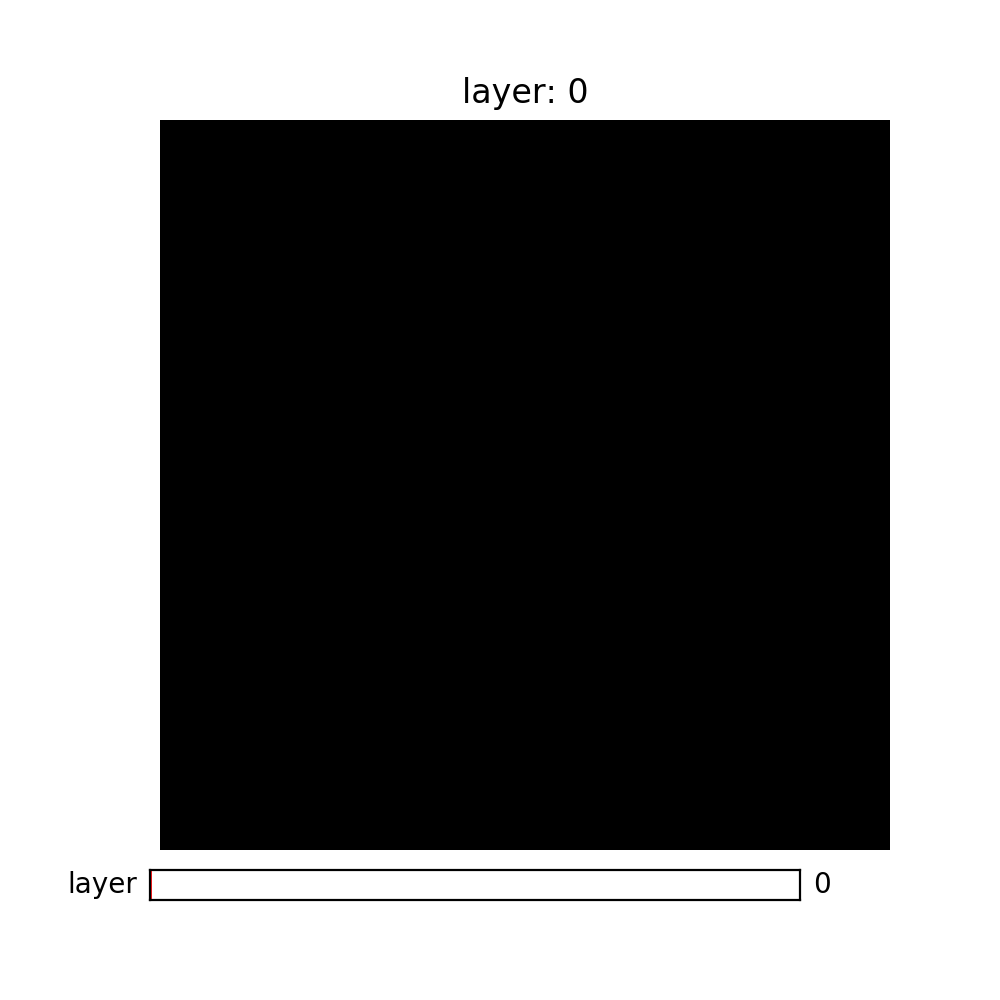

In [5]:
%matplotlib notebook
# initial the unknown 3D object
phantom = np.zeros((200,200,25),dtype="complex64")
show3DStack(np.real(phantom), axis=2, clim=(np.min(np.real(phantom)), np.max(np.real(phantom))))

# Setup solver objects

In [6]:
solver_params = dict(wavelength = wavelength, na = na, \
                     RI_measure = n_measure, sigma = 2 * np.pi * dz / wavelength,\
                     fx_illu_list = fx_illu_list, fy_illu_list = fy_illu_list, fz_illu_list = fz_illu_list, \
                     pad = False, pad_size=(50,50))
phase_obj_3d = PhaseObject3D(shape=phantom.shape, voxel_size=(dy,dx,dz), RI=n_b)
solver_obj   = TomographySolver(phase_obj_3d, **solver_params)
solver_obj.setScatteringMethod(model = "MultiPhaseContrast")

## Fill in phantom

<IPython.core.display.Javascript object>


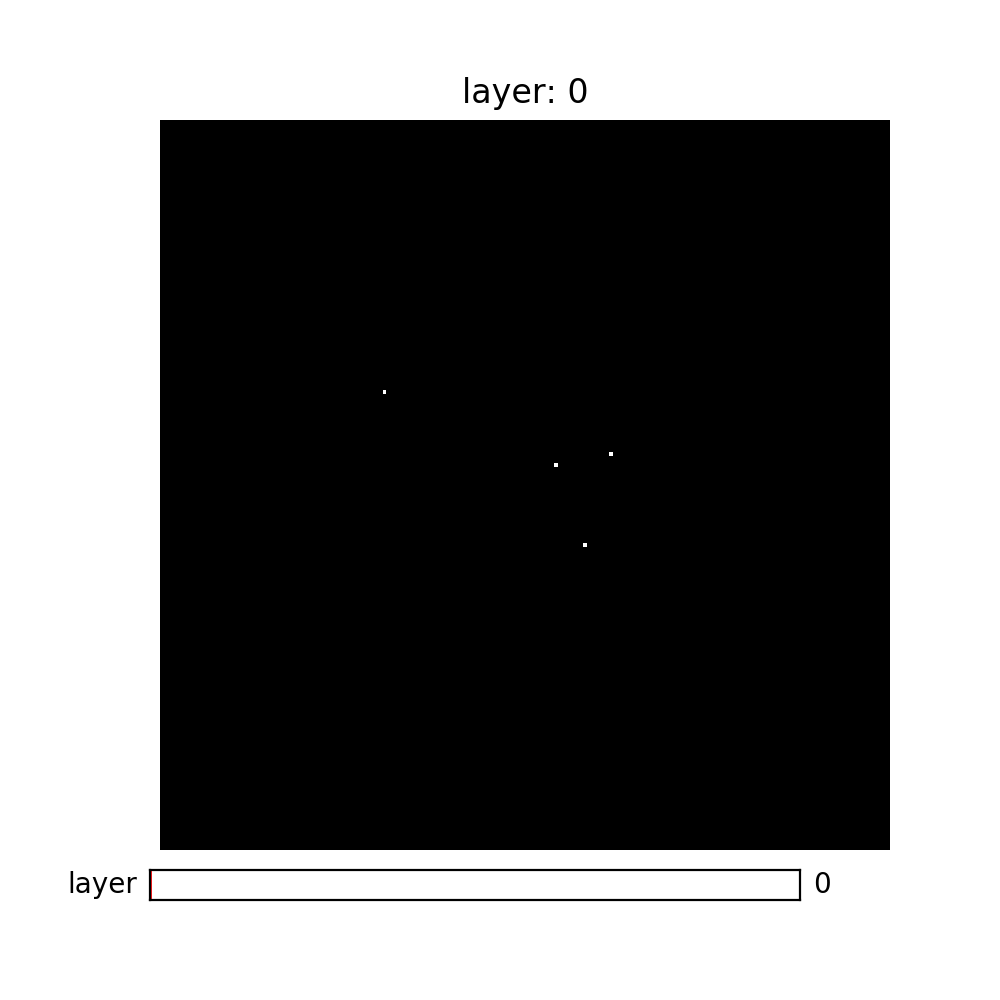

In [7]:
# inport the ground truth of the 3D object to generate forward measurements
phantom_coordinates=sio.loadmat("phantomPoisson_nooverlap.mat")
phantom_temp=phantom_coordinates["phantomPoisson"]
solver_obj._x[50:150, 50:150,:]=phantom_temp.astype("complex64") * 0.1
phantom=solver_obj._x

show3DStack(np.real(solver_obj._x), axis=2, clim=(np.min(np.real(solver_obj._x)), np.max(np.real(solver_obj._x))))

# Generate forward prediction

In [8]:
with contexttimer.Timer() as timer:
    forward_field_mb, fields = solver_obj.forwardPredict(field=True)
    print(timer.elapsed)   
forward_field_mb = np.squeeze(forward_field_mb)  
intensityfield = np.abs(forward_field_mb * np.conj(forward_field_mb))

2.7090732846409082


<IPython.core.display.Javascript object>


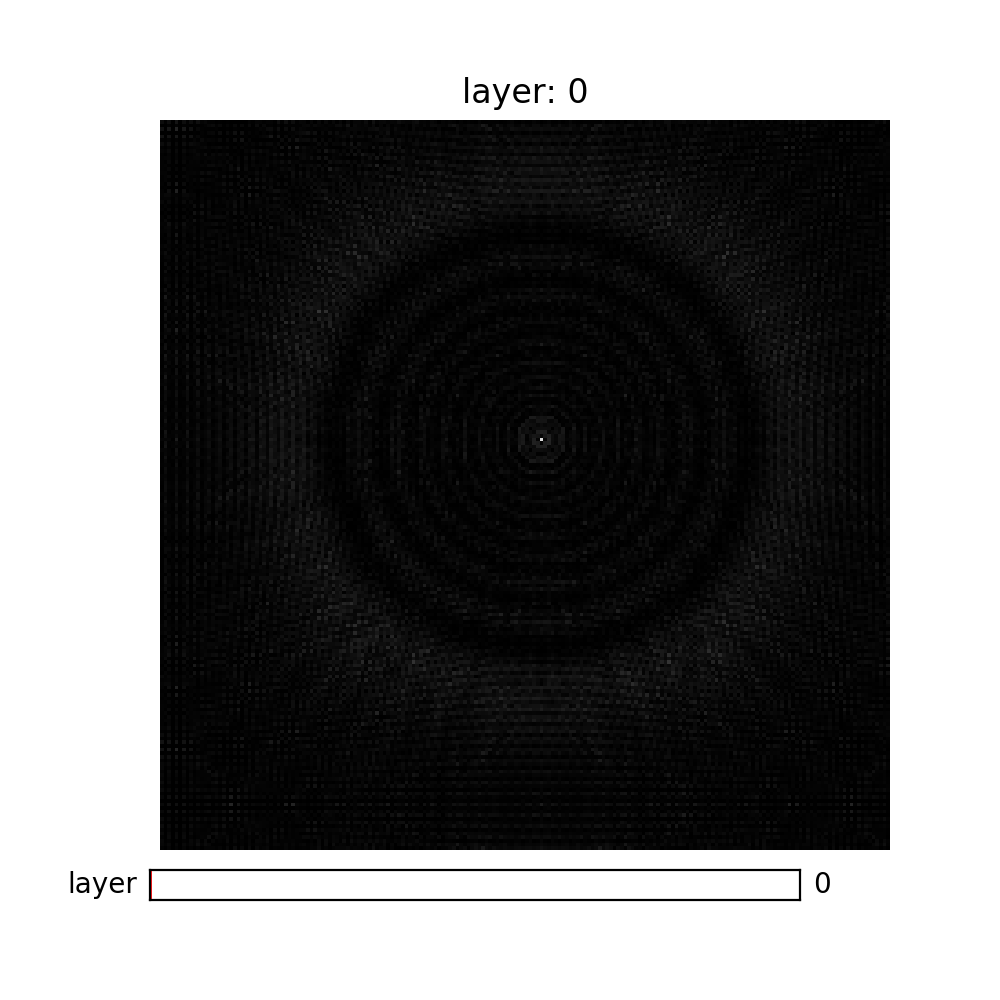

In [9]:
#plot
%matplotlib notebook
show3DStack(intensityfield, axis=2, \
            clim=(np.min(intensityfield), np.max(intensityfield)))

# Solve an inverse problem

In [10]:
#Create a class for all inverse problem parameters
configs            = AlgorithmConfigs()
configs.batch_size = 1
configs.method     = "FISTA"
configs.restart    = True
configs.max_iter   = 2000
configs.stepsize   = 3e-2
configs.error      = []
configs.reg_term   = 0

#regularizer: real
configs.pure_real  = True

configs.multiillu  = False
configs.groupillu  = False
configs.spot       = False

In [12]:
recon_obj_3d = solver_obj.solve(configs, intensityfield)

Regularizer - Pure real
---- Start of the MultiPhaseContrast algorithm ----
iteration: 1/1000, error: 0.71466, elapsed time:  5.27 seconds
iteration: 2/1000, error: 0.68620, elapsed time:  8.28 seconds
iteration: 3/1000, error: 0.65250, elapsed time: 11.28 seconds
iteration: 4/1000, error: 0.61382, elapsed time: 14.32 seconds
iteration: 5/1000, error: 0.57049, elapsed time: 17.37 seconds
iteration: 6/1000, error: 0.52314, elapsed time: 20.38 seconds
iteration: 7/1000, error: 0.47253, elapsed time: 23.38 seconds
iteration: 8/1000, error: 0.41956, elapsed time: 26.39 seconds
iteration: 9/1000, error: 0.36518, elapsed time: 29.40 seconds
iteration: 10/1000, error: 0.31036, elapsed time: 32.41 seconds
iteration: 11/1000, error: 0.25598, elapsed time: 35.42 seconds
iteration: 12/1000, error: 0.20284, elapsed time: 38.47 seconds
iteration: 13/1000, error: 0.15152, elapsed time: 41.52 seconds
iteration: 14/1000, error: 0.10240, elapsed time: 44.58 seconds
iteration: 15/1000, error: 0.05559, e

iteration: 125/1000, error: -1.95686, elapsed time: 381.55 seconds
iteration: 126/1000, error: -1.96553, elapsed time: 384.56 seconds
iteration: 127/1000, error: -1.97414, elapsed time: 387.60 seconds
iteration: 128/1000, error: -1.98268, elapsed time: 390.59 seconds
iteration: 129/1000, error: -1.99117, elapsed time: 393.59 seconds
iteration: 130/1000, error: -1.99960, elapsed time: 396.70 seconds
iteration: 131/1000, error: -2.00798, elapsed time: 399.78 seconds
iteration: 132/1000, error: -2.01630, elapsed time: 402.84 seconds
iteration: 133/1000, error: -2.02457, elapsed time: 405.86 seconds
iteration: 134/1000, error: -2.03279, elapsed time: 408.88 seconds
iteration: 135/1000, error: -2.04097, elapsed time: 411.89 seconds
iteration: 136/1000, error: -2.04909, elapsed time: 414.90 seconds
iteration: 137/1000, error: -2.05717, elapsed time: 417.93 seconds
iteration: 138/1000, error: -2.06520, elapsed time: 421.00 seconds
iteration: 139/1000, error: -2.07318, elapsed time: 424.09 sec

iteration: 248/1000, error: -2.72583, elapsed time: 754.74 seconds
iteration: 249/1000, error: -2.73051, elapsed time: 757.74 seconds
iteration: 250/1000, error: -2.73517, elapsed time: 760.74 seconds
iteration: 251/1000, error: -2.73983, elapsed time: 763.79 seconds
iteration: 252/1000, error: -2.74447, elapsed time: 766.84 seconds
iteration: 253/1000, error: -2.74911, elapsed time: 769.87 seconds
iteration: 254/1000, error: -2.75373, elapsed time: 772.91 seconds
iteration: 255/1000, error: -2.75835, elapsed time: 775.91 seconds
iteration: 256/1000, error: -2.76295, elapsed time: 778.97 seconds
iteration: 257/1000, error: -2.76755, elapsed time: 781.97 seconds
iteration: 258/1000, error: -2.77213, elapsed time: 784.99 seconds
iteration: 259/1000, error: -2.77670, elapsed time: 787.99 seconds
iteration: 260/1000, error: -2.78126, elapsed time: 791.01 seconds
iteration: 261/1000, error: -2.78581, elapsed time: 794.06 seconds
iteration: 262/1000, error: -2.79035, elapsed time: 797.16 sec

iteration: 370/1000, error: -3.21320, elapsed time: 1124.20 seconds
iteration: 371/1000, error: -3.21662, elapsed time: 1127.33 seconds
iteration: 372/1000, error: -3.22003, elapsed time: 1130.40 seconds
iteration: 373/1000, error: -3.22343, elapsed time: 1133.41 seconds
iteration: 374/1000, error: -3.22683, elapsed time: 1136.41 seconds
iteration: 375/1000, error: -3.23022, elapsed time: 1139.45 seconds
iteration: 376/1000, error: -3.23361, elapsed time: 1142.49 seconds
iteration: 377/1000, error: -3.23698, elapsed time: 1145.53 seconds
iteration: 378/1000, error: -3.24035, elapsed time: 1148.53 seconds
iteration: 379/1000, error: -3.24372, elapsed time: 1151.58 seconds
iteration: 380/1000, error: -3.24708, elapsed time: 1154.62 seconds
iteration: 381/1000, error: -3.25043, elapsed time: 1157.64 seconds
iteration: 382/1000, error: -3.25377, elapsed time: 1160.66 seconds
iteration: 383/1000, error: -3.25711, elapsed time: 1163.73 seconds
iteration: 384/1000, error: -3.26044, elapsed ti

iteration: 491/1000, error: -3.58328, elapsed time: 1490.84 seconds
iteration: 492/1000, error: -3.58606, elapsed time: 1493.94 seconds
iteration: 493/1000, error: -3.58883, elapsed time: 1497.02 seconds
iteration: 494/1000, error: -3.59160, elapsed time: 1500.04 seconds
iteration: 495/1000, error: -3.59436, elapsed time: 1503.09 seconds
iteration: 496/1000, error: -3.59711, elapsed time: 1506.13 seconds
iteration: 497/1000, error: -3.59987, elapsed time: 1509.17 seconds
iteration: 498/1000, error: -3.60261, elapsed time: 1512.20 seconds
iteration: 499/1000, error: -3.60535, elapsed time: 1515.23 seconds
iteration: 500/1000, error: -3.60809, elapsed time: 1518.23 seconds
iteration: 501/1000, error: -3.61082, elapsed time: 1521.32 seconds
iteration: 502/1000, error: -3.61355, elapsed time: 1524.39 seconds
iteration: 503/1000, error: -3.61627, elapsed time: 1527.42 seconds
iteration: 504/1000, error: -3.61898, elapsed time: 1530.49 seconds
iteration: 505/1000, error: -3.62170, elapsed ti

iteration: 612/1000, error: -3.88819, elapsed time: 1858.79 seconds
iteration: 613/1000, error: -3.89052, elapsed time: 1861.81 seconds
iteration: 614/1000, error: -3.89284, elapsed time: 1864.92 seconds
iteration: 615/1000, error: -3.89517, elapsed time: 1868.02 seconds
iteration: 616/1000, error: -3.89748, elapsed time: 1871.08 seconds
iteration: 617/1000, error: -3.89980, elapsed time: 1874.08 seconds
iteration: 618/1000, error: -3.90212, elapsed time: 1877.16 seconds
iteration: 619/1000, error: -3.90443, elapsed time: 1880.20 seconds
iteration: 620/1000, error: -3.90674, elapsed time: 1883.23 seconds
iteration: 621/1000, error: -3.90905, elapsed time: 1886.32 seconds
iteration: 622/1000, error: -3.91135, elapsed time: 1889.44 seconds
iteration: 623/1000, error: -3.91365, elapsed time: 1892.49 seconds
iteration: 624/1000, error: -3.91594, elapsed time: 1895.48 seconds
iteration: 625/1000, error: -3.91824, elapsed time: 1898.47 seconds
iteration: 626/1000, error: -3.92052, elapsed ti

iteration: 733/1000, error: -4.14993, elapsed time: 2225.77 seconds
iteration: 734/1000, error: -4.15197, elapsed time: 2228.77 seconds
iteration: 735/1000, error: -4.15401, elapsed time: 2231.77 seconds
iteration: 736/1000, error: -4.15605, elapsed time: 2234.78 seconds
iteration: 737/1000, error: -4.15809, elapsed time: 2237.78 seconds
iteration: 738/1000, error: -4.16012, elapsed time: 2240.80 seconds
iteration: 739/1000, error: -4.16215, elapsed time: 2243.87 seconds
iteration: 740/1000, error: -4.16418, elapsed time: 2246.88 seconds
iteration: 741/1000, error: -4.16621, elapsed time: 2249.97 seconds
iteration: 742/1000, error: -4.16823, elapsed time: 2252.99 seconds
iteration: 743/1000, error: -4.17025, elapsed time: 2256.06 seconds
iteration: 744/1000, error: -4.17227, elapsed time: 2259.09 seconds
iteration: 745/1000, error: -4.17429, elapsed time: 2262.11 seconds
iteration: 746/1000, error: -4.17631, elapsed time: 2265.16 seconds
iteration: 747/1000, error: -4.17832, elapsed ti

iteration: 854/1000, error: -4.37796, elapsed time: 2592.98 seconds
iteration: 855/1000, error: -4.37968, elapsed time: 2596.04 seconds
iteration: 856/1000, error: -4.38139, elapsed time: 2599.13 seconds
iteration: 857/1000, error: -4.38311, elapsed time: 2602.26 seconds
iteration: 858/1000, error: -4.38482, elapsed time: 2605.28 seconds
iteration: 859/1000, error: -4.38653, elapsed time: 2608.29 seconds
iteration: 860/1000, error: -4.38824, elapsed time: 2611.30 seconds
iteration: 861/1000, error: -4.38995, elapsed time: 2614.33 seconds
iteration: 862/1000, error: -4.39167, elapsed time: 2617.34 seconds
iteration: 863/1000, error: -4.39337, elapsed time: 2620.33 seconds
iteration: 864/1000, error: -4.39508, elapsed time: 2623.33 seconds
iteration: 865/1000, error: -4.39679, elapsed time: 2626.40 seconds
iteration: 866/1000, error: -4.39849, elapsed time: 2629.57 seconds
iteration: 867/1000, error: -4.40020, elapsed time: 2632.65 seconds
iteration: 868/1000, error: -4.40191, elapsed ti

iteration: 975/1000, error: -4.57618, elapsed time: 2960.06 seconds
iteration: 976/1000, error: -4.57769, elapsed time: 2963.08 seconds
iteration: 977/1000, error: -4.57920, elapsed time: 2966.10 seconds
iteration: 978/1000, error: -4.58071, elapsed time: 2969.10 seconds
iteration: 979/1000, error: -4.58222, elapsed time: 2972.11 seconds
iteration: 980/1000, error: -4.58372, elapsed time: 2975.10 seconds
iteration: 981/1000, error: -4.58522, elapsed time: 2978.13 seconds
iteration: 982/1000, error: -4.58672, elapsed time: 2981.20 seconds
iteration: 983/1000, error: -4.58821, elapsed time: 2984.28 seconds
iteration: 984/1000, error: -4.58970, elapsed time: 2987.29 seconds
iteration: 985/1000, error: -4.59119, elapsed time: 2990.28 seconds
iteration: 986/1000, error: -4.59268, elapsed time: 2993.29 seconds
iteration: 987/1000, error: -4.59416, elapsed time: 2996.32 seconds
iteration: 988/1000, error: -4.59564, elapsed time: 2999.32 seconds
iteration: 989/1000, error: -4.59712, elapsed ti

## Plotting results

<IPython.core.display.Javascript object>


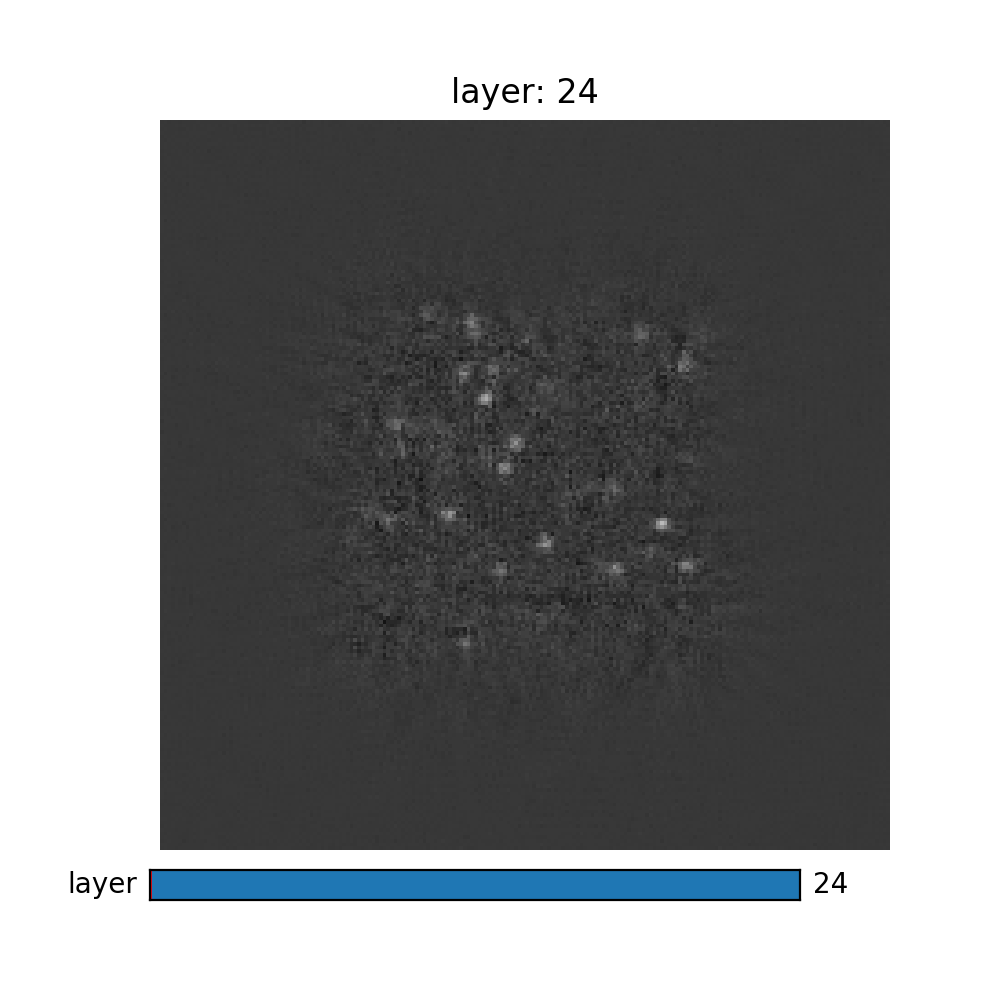

In [13]:
current_rec = recon_obj_3d
cost = configs.error
%matplotlib notebook
show3DStack(np.real(current_rec), axis=2, clim=(np.min(np.real(current_rec[:,:,:])), np.max(np.real(current_rec[:,:,:]))))

<IPython.core.display.Javascript object>


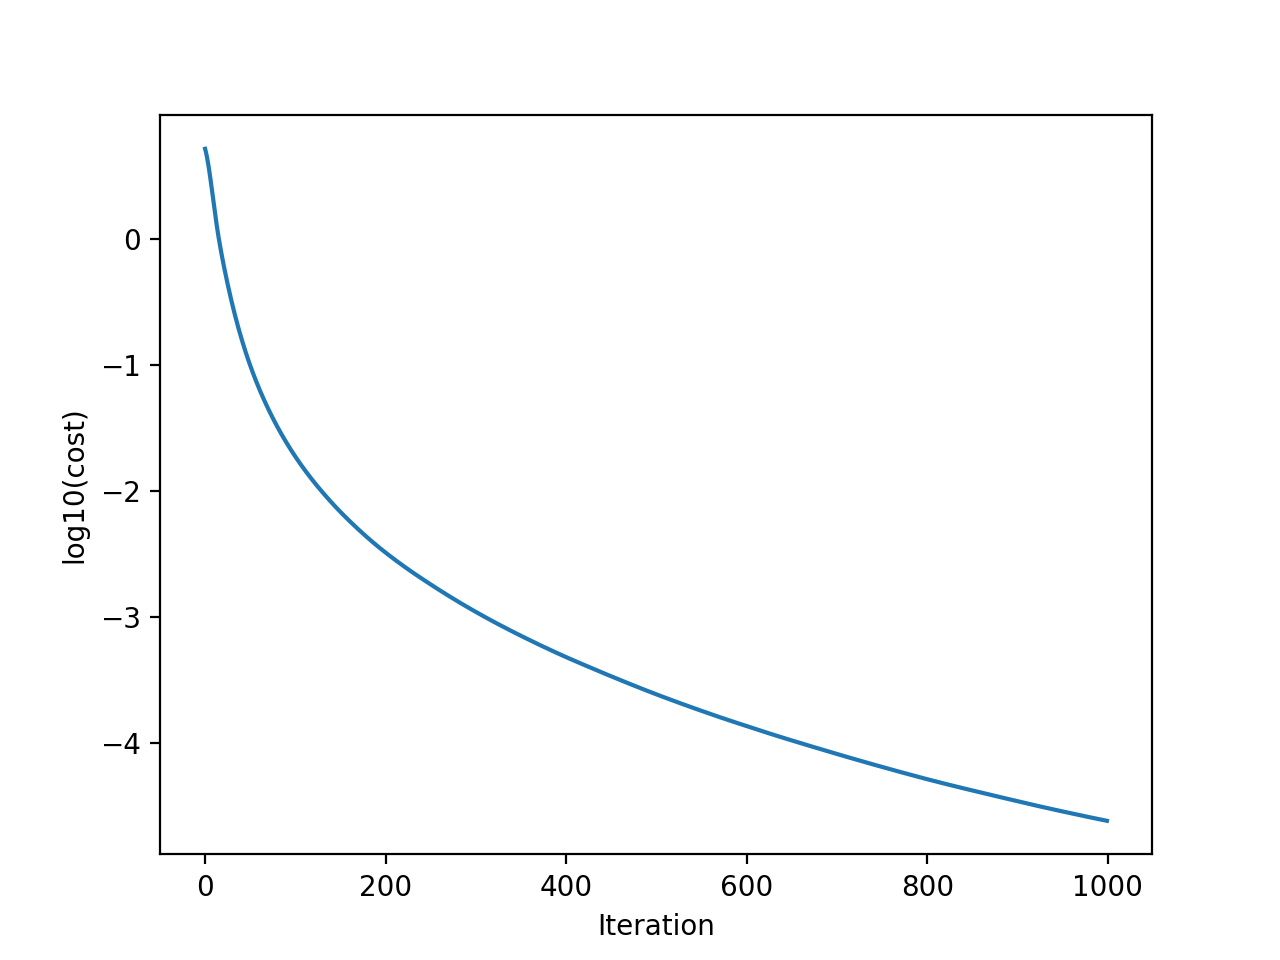

Text(0, 0.5, 'log10(cost)')

In [14]:
plt.figure()
plt.plot(np.log10(cost))
plt.xlabel("Iteration")
plt.ylabel("log10(cost)")